### Scope: We'll be trying to predict a classification - survival or deceased by implementing Logistic Regression

## Data source:[Kaggle](https://www.kaggle.com/c/titanic)

In [1]:
## Installing and importing libraries

In [2]:
#The following command lines can be used to install the libraries incase they have been installed:

#conda install pandas
#conda install numpy
#conda install matplotlib
#conda install seaborn

In [3]:
#Let's import some libraries to get started

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
sns.set_style('whitegrid')

In [5]:
titanic = sns.load_dataset('titanic')

In [6]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [7]:
# Let's visualize our data using seaborn

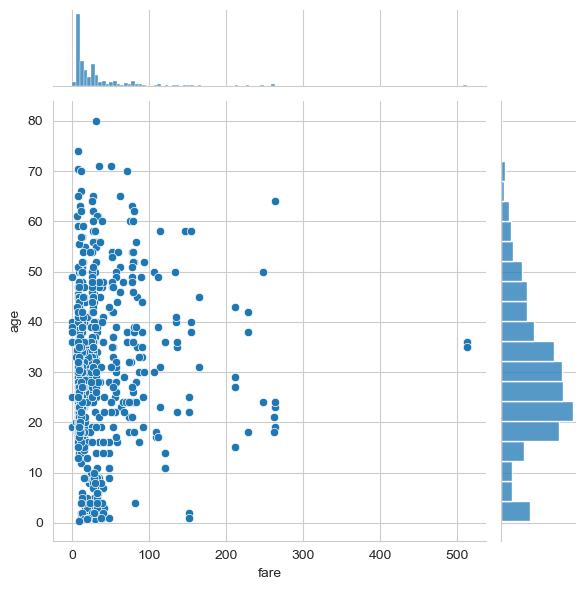

In [8]:
sns.jointplot(x='fare',y='age',data=titanic)

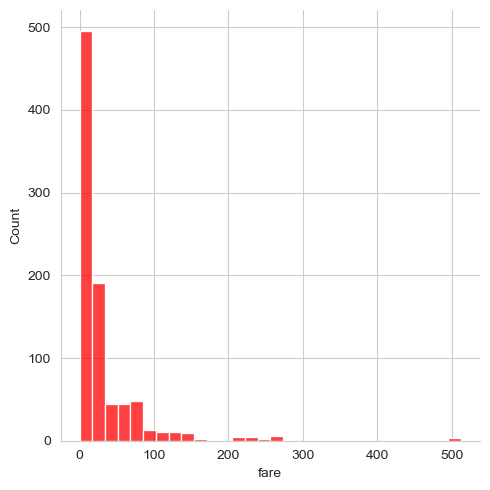

In [9]:
sns.displot(titanic['fare'],bins=30,kde=False,color='red')

<AxesSubplot:xlabel='class', ylabel='age'>

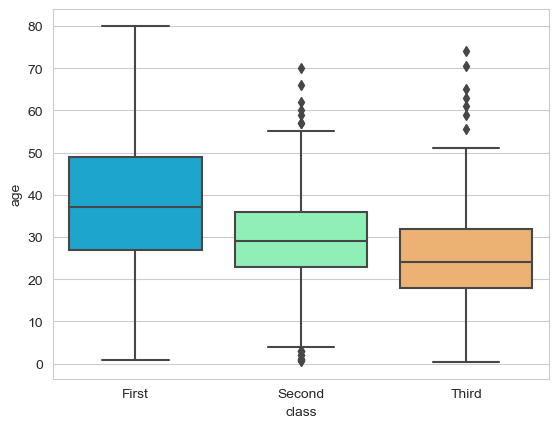

In [10]:
sns.boxplot(x='class',y='age',data=titanic,palette='rainbow')

<AxesSubplot:xlabel='sex', ylabel='count'>

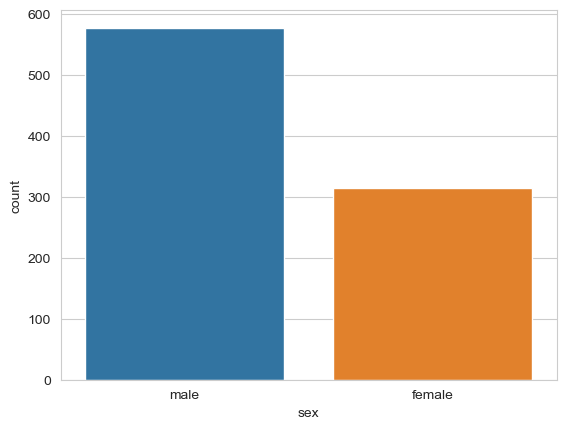

In [11]:
sns.countplot(x='sex',data=titanic)

In [12]:
# let us check the correction in the data

Text(0.5, 1.0, 'titanic.corr()')

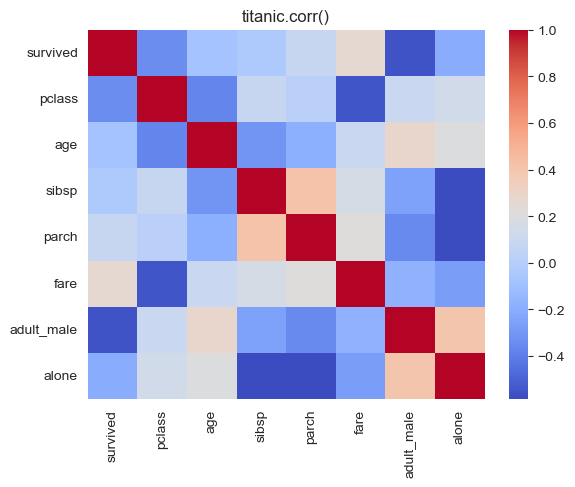

In [13]:
sns.heatmap(titanic.corr(),cmap='coolwarm')
plt.title('titanic.corr()')

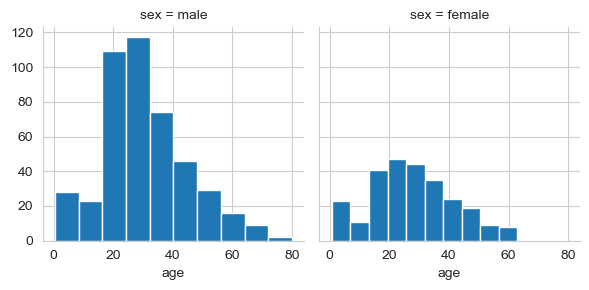

In [14]:
#its important to check the distribution of the sex and age in the data

g = sns.FacetGrid(data=titanic,col='sex')
g.map(plt.hist,'age')

#### Training our model

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [14]:
train = pd.read_csv('titanic_train.csv')

In [15]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

#### Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

<AxesSubplot:>

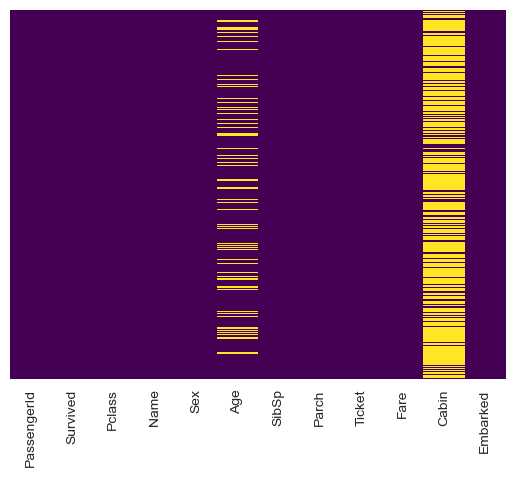

In [15]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later.

Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.

<AxesSubplot:xlabel='Survived', ylabel='count'>

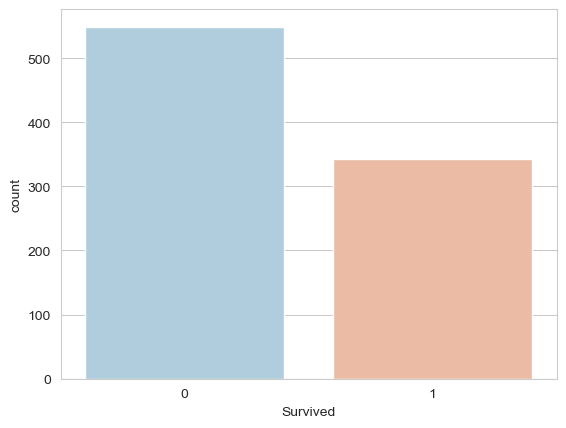

In [38]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

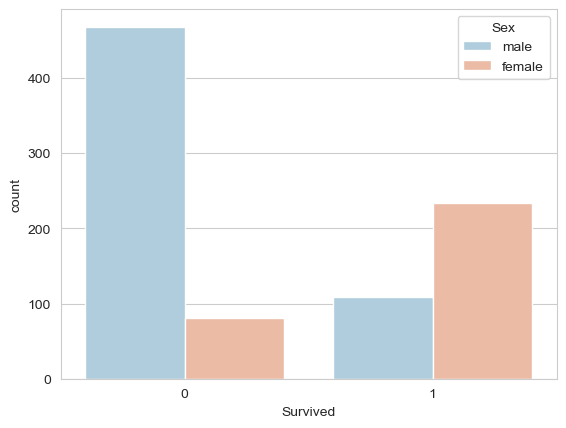

In [39]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

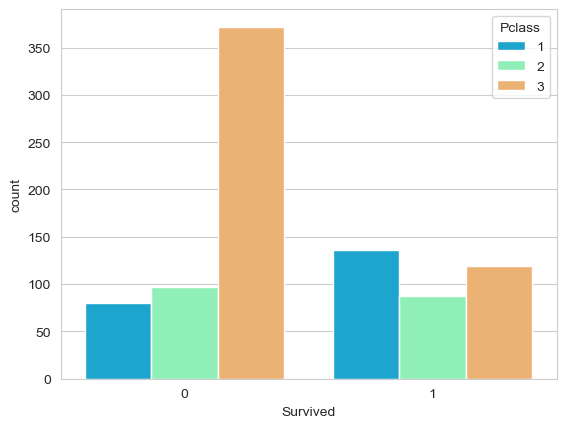

In [40]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

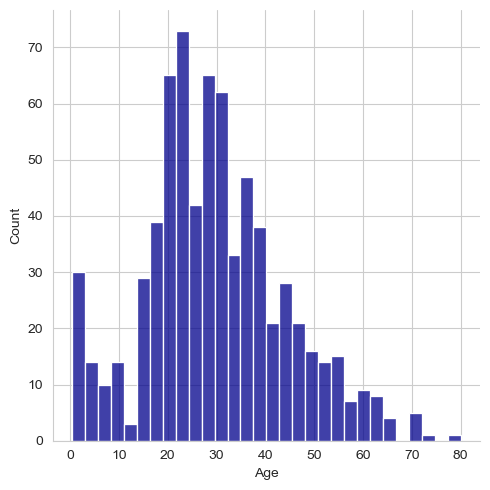

In [41]:
sns.displot(train['Age'].dropna(),kde=False,color='darkblue',bins=30)

<AxesSubplot:>

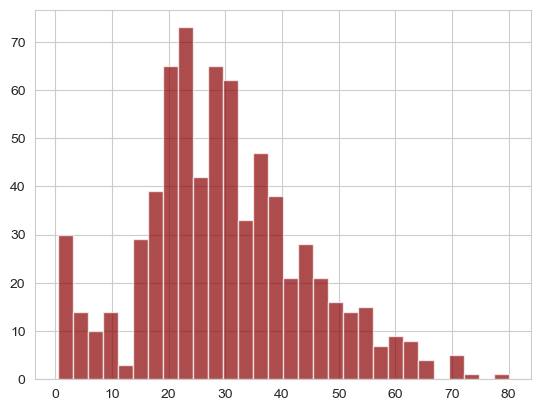

In [42]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

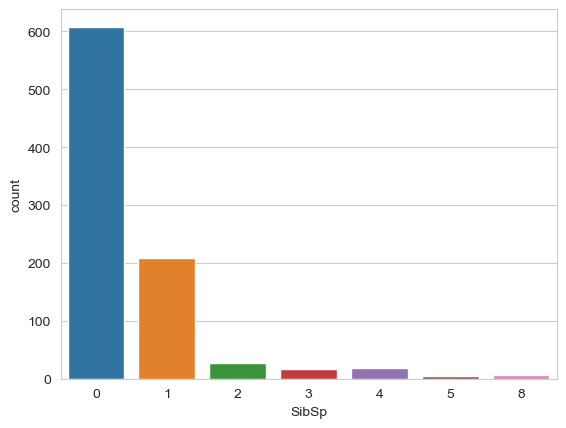

In [43]:
sns.countplot(x='SibSp',data=train)

<AxesSubplot:>

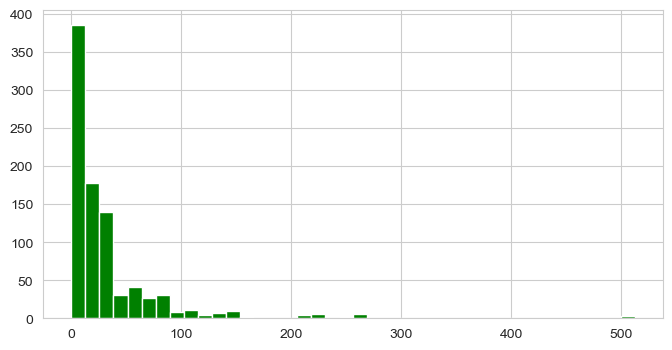

In [44]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))


### Using Cufflinks for plots

Let's take a quick look at using cufflinks for our visualization

In [45]:
import cufflinks as cf
cf.go_offline()

In [47]:
train['Fare'].iplot(kind='hist',bins=30,color='orange')


### Data Cleaning

We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

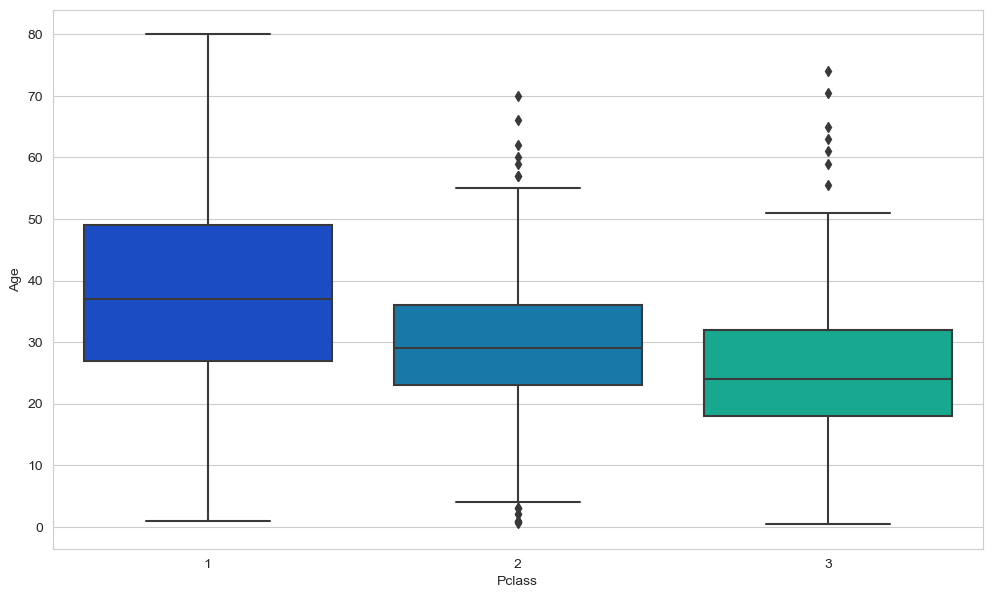

In [48]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.
Let's create a function to input the average values in the null values.

In [50]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Apply the function

In [51]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

<AxesSubplot:>

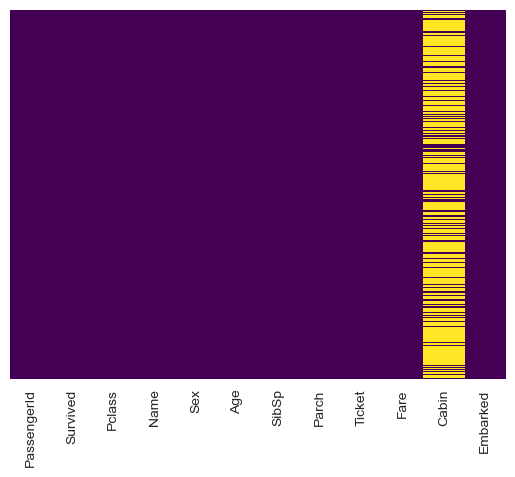

In [52]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

The function worked perfectly but we have a second task in the data cleaning which is to drop the Cabin column and the row in Embarked that is NaN.

In [53]:
train.drop('Cabin',axis=1,inplace=True)

In [54]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [55]:
train.dropna(inplace=True)

#### Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas, otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [57]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [58]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [59]:
train = pd.concat([train,sex,embark],axis=1)

In [60]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Our data is ready for our model

#### Building a Logistic Regression model

Let's start by splitting our data into a training set and test set.

#### Train Test Split

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

#### Training and Prediction

In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
logmodel = LogisticRegression(max_iter=10000)
logmodel.fit(X_train,y_train)

LogisticRegression(max_iter=10000)

In [65]:
predictions = logmodel.predict(X_test)


Let's move on to evaluate our model

### Evaluation

We can check precision, recall, f1-score using classification report!

In [67]:
from sklearn.metrics import classification_report

In [68]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.91      0.87       163
           1       0.84      0.69      0.76       104

    accuracy                           0.83       267
   macro avg       0.83      0.80      0.81       267
weighted avg       0.83      0.83      0.82       267

